

---

---


                     *** DETECCIÓN DEL LÍMITE AGUA-TIERRA CON METODOLOGÍAS SEMI-AUTOMÁTICAS ***


---

---

El siguiente código genera un producto que permite hacer una distinción clara entre el entorno marino-fluvial y terrestre de una zona y un período en particular. El resultado de la clasificación se puede descargar como un archivo raster o vectorial.



La metodología se basa en un código elaborado en Google Earth Engine por el Departamento de Aplicaciones Geoespaciales de la Dirección de Información Geoespacial del Instituto Geográfico Nacional titulado "Detección del límite agua-tierra mediante el algoritmo mínima distancia en la nube de Google Earth Engine" que a través del uso de técnicas de teledetección, imágenes SENTINEL-2A/B MSI Nivel 1C y métodos estadísticos como distancia mínima se obtiene un producto de clasificación de Agua/Tierra.


---




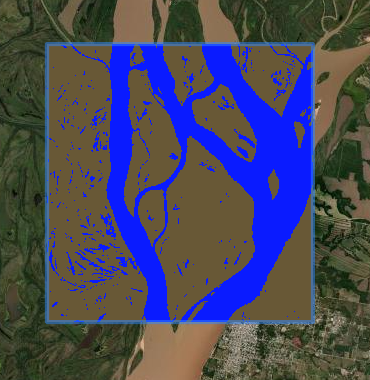



---

Algunas cuestiones a tener en cuenta:

* Se recomienda **ejecutar el código con las solapas colapsadas**, así se asegura que se ejecutan todas las líneas necesarias.

* Sólo las **solapas con * se deben abrir luego de ejecutarlas**, para realizar alguna acción.

* En Colab, las **sesiones son temporales** y los recursos son compartidos, por lo que si no hay interacción con el cuaderno en un cierto periódo de tiempo la sesión se desconecta y probablemente al ejecutar alguna línea de código se generará un **error**. Para solucionarlo, simplemente se deben volver a ejecutar las solapas desde el inicio.

---




---



En primer lugar, debemos conectarnos a nuestro Drive personal ejecutando la siguiente celda y aceptando permisos.




Luego, debemos autorizar el acceso a GEE. Para ello, se debe ejecutar la celda, ingresar a la URL y seguir la instrucciones. Se generará un código de verificación que deberá ser pegado a continuación.
texto en negrita

# Ejecutar esta celda


## 1. Instalar bibliotecas


In [60]:
!pip install geemap
!pip install requests
!pip install pycrs

## 2. Instalar módulos


In [61]:
import ee
import geemap
import ipywidgets as widgets
from datetime import datetime
import pandas as pd
import requests
from IPython.display import HTML, display
import os

from zmq.constants import NULL

## 3. Mapa base




In [62]:
#ee.Initialize()# Inicializar Earth Engine

Map = geemap.Map(center=(-40, -64), zoom=4) #crear el mapa inetrcativo con coordenadas especificas
Map.add_basemap('HYBRID')

## 4. Código de interfaz visual

In [63]:
#..................................................... Cartas
cartas = ee.FeatureCollection("projects/e-tenglerevelyn/assets/Cartas_50000")

# Obtener los valores únicos de la columna "carac"
valoresCarac = cartas.aggregate_array("carac").distinct().getInfo()

# Crear etiquetas
etiqueta = widgets.Label(value='Seleccione una carta 1:50.000')
etiqueta_fecha = widgets.Label(value='Elija el período de las imágenes')
etiqueta_vacia = widgets.Label(value='__________________________________________________________________________________________')

# Crear una lista desplegable con los registros
lista_registros = widgets.Select(options=valoresCarac, description='Opciones')

# Definir una función para manejar el evento de cambio de selección
def on_value_change(change):
    valor_carta = change['new']
    geometria_seleccionada = cartas.filter(ee.Filter.eq("carac", valor_carta))

    Map.addLayer(geometria_seleccionada, {}, 'Geometría seleccionada')

# Registrar la función de manejo del evento de cambio
lista_registros.observe(on_value_change, names='value')

#..................................................... Período de tiempo
date_picker_inicio = widgets.DatePicker(
    description='Fecha inicial:',
    value=datetime.now().date(),  # Establecer la fecha actual como valor inicial
    disabled=False
)

date_picker_fin = widgets.DatePicker(
    description='Fecha final:',
    value=datetime.now().date(),  # Establecer la fecha actual como valor inicial
    disabled=False
)

hbox_fecha= widgets.HBox([date_picker_inicio, date_picker_fin])

#..............................................................

opcion_area = widgets.RadioButtons(
    options=['Dibujar polígono en el mapa', 'Utilizar carta 1:50.000'],
    description='Seleccionar forma de determinar el área: ',
    layout=widgets.Layout(width='50%')
)



## 5. Entrenamiento

### Muestras preestablecidas del entrenamiento

In [64]:
# MUESTRAS
muestras = ee.FeatureCollection("projects/ee-gonzalodgign/assets/AguaTierra/LineadeCosta/Muestras_Argentina_Borrador")
#Map.addLayer(muestras, {}, 'muestras')

# ZONA DE ENTRENAMIENTO
zona_muestreo = ee.FeatureCollection("projects/ee-tenglerevelyn/assets/AREA_A-T")
#Map.addLayer(zona_muestreo, {}, 'zona_muestreo')

### Agregar muestras para un mejor resultado

Para agregar puntos de muestreo se debe subir a drive 3 archivos:

- Un shp con puntos de muestreo para categoría agua (debe tener una columna class con valor 1)

- Un shp con puntos de muestreo para la categoría no agua/tierra (debe tener una columna class con valor 2)

- Un shp de polígono cuya extención debe encerrar todos los nuevos puntos de muestreo anteriores.

Para que funcione se debe descomentar las líneas con un solo # del siguiente código.



In [65]:
## ...... AGUA

#shp_path_agua = "ACÁ VA LA RUTA AL ARCHIVO SHP DE LOS PUNTOS DE MUESTREO DE LA CATEGORÍA AGUA EN DRIVE"

### Cargar archivo SHP como FeatureCollection utilizando geemap
#muestras_extra_agua = geemap.shp_to_ee(shp_path_agua)

### Visualizar FeatureCollection en el mapa
#Map.addLayer(muestras_extra_agua, {}, 'muestras_extra_A')

### Unir las muestras de agua nuevas con las preestablecidas
#muestras.merge(muestras_extra_agua)

In [66]:
## ...... NO AGUA/TIERRA

#shp_path_tierra = "ACÁ VA LA RUTA AL ARCHIVO SHP DE LOS PUNTOS DE MUESTREO DE LA CATEGORÍA NO AGUA/TIERRA EN DRIVE"

### Cargar archivo SHP como FeatureCollection utilizando geemap
#muestras_extra_tierra = geemap.shp_to_ee(shp_path_tierra)

### Visualizar FeatureCollection en el mapa
#Map.addLayer(muestras_extra_tierra, {}, 'muestras_extra_T')

### Unir las muestras de agua nuevas con las preestablecidas
#muestras.merge(muestras_extra_tierra)

In [67]:
## ...... EXTENCION

#shp_path_extencion = "ACÁ VA LA RUTA AL ARCHIVO SHP DEL POLÍGONO EN DRIVE"

### Cargar archivo SHP como FeatureCollection utilizando geemap
#extencion_extra = geemap.shp_to_ee(shp_path_extencion)

### Visualizar FeatureCollection en el mapa
#Map.addLayer(extencion_extra, {}, 'extencion_extra')

### Unir la extencion nueva con la preestablecida
#zona_muestreo.merge(extencion_extra)

### Colección de imágenes del entrenamiento

Se puede modificar el período de entrenamiento.

In [68]:
# Colección de imágenes Sentinel 2
s2 = ee.ImageCollection("COPERNICUS/S2") \
    .filterDate('2023-01-01', '2023-03-31') \
    .filterBounds(zona_muestreo) \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 0.2)

s2c_ = s2.reduce(ee.Reducer.mean())
s2c = s2c_.clip(zona_muestreo)


### Indices espectrales

In [69]:
# NDWI
NDWI = s2c.normalizedDifference(['B3_mean', 'B8_mean']).rename('NDWImean')

# Stack
stackIslas_a = NDWI

### Entrenamiento

In [70]:
muestras_1 = muestras.randomColumn('random')

# División de muestras
entrenamiento = muestras_1.filter(ee.Filter.lt('random', 0.7))
validacion = muestras_1.filter(ee.Filter.gt('random', 0.7))

# Entrenar el clasificador utilizando datos de muestras
training = stackIslas_a.sampleRegions(
  collection=entrenamiento,
  properties=['class', 'random'],
  scale=30
)

# Bandas a utilizar en la clasificación
bandas_sel = ['NDWImean']

# Entrenar clasificador RF
classifier = ee.Classifier.minimumDistance().train(
    features = training,
    classProperty = 'class',
    inputProperties = bandas_sel
)

### Validación

In [71]:
###Si se desea ver los resultados de la validación se debe descomentar las lineas con un solo # del siguiente código
### Clasifico la imagen
#classified_entrenamiento = stackIslas_a.classify(classifier)

### Muestrear las regiones
#test = classified_entrenamiento.sampleRegions(**{
#  'collection': validacion,
#  'properties': ['class'],
#  'scale': 30
#})

## Obtener la matriz de confusión
#testConfusionMatrix = test.errorMatrix('class', 'classification')

### Convertir la matriz de confusión a un DataFrame de pandas
#confusion_df = pd.DataFrame(testConfusionMatrix.getInfo())

### Imprimir la matriz de confusión como tabla
#print(confusion_df)

## 6. Clasificación

In [83]:
classified_b = None
extencion = None

def obtenerFecha():
    # Obtener las fechas seleccionadas
    fecha_inicio = date_picker_inicio.value
    fecha_fin = date_picker_fin.value

    # Convertir las fechas al formato deseado ('YYYY-MM-DD')
    fecha_inicio_str = fecha_inicio.strftime('%Y-%m-%d')
    fecha_fin_str = fecha_fin.strftime('%Y-%m-%d')

    # Convertir las fechas en objetos ee.Date
    fecha_inicio_ee = ee.Date(fecha_inicio_str)
    fecha_fin_ee = ee.Date(fecha_fin_str)

    # Utilizar las fechas convertidas en el parámetro time_interval
    time_interval = (fecha_inicio_ee, fecha_fin_ee)

    # Retornar el resultado
    return time_interval


def area_extencion():
  global extencion
    ####....................................................................... formas de elegir un área de interés

  selected_value = opcion_area.value
  print("Valor seleccionado:", selected_value)

  if (selected_value == 'Dibujar polígono en el mapa'):
  # ..................................................Región DIBUJADA
    Map.draw_features
    if (Map.draw_last_feature != None):
      extencion = ee.FeatureCollection(Map.draw_last_feature)#Roi Bounding Box (guarda en variable el bbox)
    #print("ok")
  else:
  # ..................................................Región CARTA
    valor_carta = lista_registros.value
    geometria_seleccionada = cartas.filter(ee.Filter.eq("carac", valor_carta))
    extencion = ee.FeatureCollection(geometria_seleccionada)

  return extencion


In [84]:
def clasificacion_agua_tierra(b):

  global classified_b  # Indica que deseas utilizar la variable global
####..............................................................................................................
  extencion = area_extencion()

# .................................................. Colección de imágenes Sentinel 2
  s2_b = ee.ImageCollection("COPERNICUS/S2") \
      .filterDate(*obtenerFecha()) \
      .filterBounds(extencion) \
      .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 0.2)

  s2c_b = s2_b.reduce(ee.Reducer.mean())
  s2c_b = s2c_b.clip(extencion)

# NDWI
  NDWI_b = s2c_b.normalizedDifference(['B3_mean', 'B8_mean']).rename('NDWImean')

# Stack
  stackIslas_b = NDWI_b

# Clasificar la imagen
  classified_b = stackIslas_b.classify(classifier)

# Añadir capa clasificada al mapa
  Map.addLayer(classified_b, {'min': 1, 'max': 2, 'palette': N1Color}, 'Clasificado')
  print("Se ha cargado en el mapa el resultado de la clasificación")

In [85]:
#----------  Botón  ----------#
# Establece el ancho del botón
button_width = '100px'  # Puedes ajustar el valor según tus necesidades

submit = widgets.Button(
    description='Clasificar',
    button_style='primary',
    tooltip='Click en el botón para detectar agua-tierra',
    layout=widgets.Layout(width=button_width)
)

output_s = widgets.Output()

#si se presiona el botón se llama a la función
submit.on_click(clasificacion_agua_tierra)

## 7. Estilo

In [75]:
# Color de categorías Agua/NoAgua
N1Color = [
    '#0000ff',  # Corriente de agua - clase 1
    '#764C04'  # Tierra/NoAgua - clase 2
]

imageVisParam2 = {
    'bands': ["B3_mean", "B2_mean", "B1_mean"],
    'gamma': 1,
    'max': 2789.728888888889,
    'min': 1875.3822222222223,
    'opacity': 1
}

## 8. Descarga Raster *

Este paso es **opcional**. Al ejecutarlo se genera un link para la descarga del archivo Raster de la clasificación (extender la solapa para verlo).

*Tener en cuenta que GEE tiene algunas limitaciones de procesamiento, por lo que puede lanzar errores cuando la región sea muy grande. Para ello es recomendable trabajar con regiones del tamaño de una carta 1:50.000 o menores

In [76]:

def descarga_raster(b):
  print(f'Procesando descarga Raster...')
  global classified_b  # Indica que deseas utilizar la variable global
  global extencion

  url = classified_b.getDownloadURL({
      'name': 'LimiteAguaTierra',
      'scale': 10,
      'region': extencion.geometry()
  })

  print(f'Ingresar al siguiente link para descargar el archivo resultante en formato Raster: {url}')

In [77]:
# Establece el ancho del botón
button_width_2 = '200px'  # Puedes ajustar el valor según tus necesidades

boton_descarga_raster = widgets.Button(
    description='Descargar Raster',
    button_style='primary',
    tooltip='Click en el botón para descargar el resultado en formato raster',
    layout=widgets.Layout(width=button_width_2)
)

#si se presiona el botón se llama a la función
boton_descarga_raster.on_click(descarga_raster)



## 7. Vectorización y descarga *

Este paso es **opcional**.

El archivo vectorial resultante se **descarga en Drive**. En la pestaña "Descargar archivo vectroizado" se puede modificar la línea "descripcion = 'Linea_de_Agua'" con el nombre que tendrá el archivo. La descarga puede tardar varios minutos y una vez finalizado se debe buscar el archivo en nuestro Drive.

En el resultado final el agua se distingue por la columna label con valor 1 y no agua/tierra el valor 2.


*Tener en cuenta que GEE tiene algunas limitaciones de procesamiento, por lo que puede lanzar errores cuando la región sea muy grande. Para ello es recomendable trabajar con regiones del tamaño de una carta 1:50.000 o menores


### Vectorizar

In [78]:
def descarga_vectorial(b):
    # Deshabilita el botón mientras se procesa la exportación
    submit.disabled = True

    # Muestra un mensaje de progreso
    with output:
        print('Procesando descarga Vectorial...')

    global classified_b
    global extencion

    vectores = classified_b.reduceToVectors(
        reducer=ee.Reducer.countEvery(),
        scale=10,
        geometry=extencion
    )

    Agua = ee.FeatureCollection(vectores)

    descripcion = 'Linea_de_Agua'
    formato = 'SHP'

    exportacion = ee.batch.Export.table.toDrive(
        collection=Agua,
        description=descripcion,
        folder='',
        fileNamePrefix=descripcion,
        fileFormat=formato
    )

    # Iniciar la exportación
    exportacion.start()

    status = exportacion.status()

    while status['state'] in ['READY', 'RUNNING']:
        # Realiza alguna acción mientras la exportación está en progreso
        pass

    if status['state'] == 'COMPLETED':
        with output:
            print('El archivo ha sido descargado en Drive. Búscalo como Linea_de_Agua.')

    # Habilita el botón nuevamente
    submit.disabled = False




### Descargar archivo vectorizado

In [79]:
#---------------------------------------------
boton_descarga_vectorial = widgets.Button(
    description='Descargar Vectorial',
    button_style='primary',
    tooltip='Click en el botón para descargar el resultado en formato vectorial',
    layout=widgets.Layout(width=button_width_2)
)

output = widgets.Output()

#si se presiona el botón se llama a la función
boton_descarga_vectorial.on_click(descarga_vectorial)

## 8. Tratamiento al archivo vectorial

Una vez descargado el vector, se le puede realizar una serie de procesos para un mejor resultado. Para ello se pueden utilizar las herramientas de QGis de simplificado y suavizado.

# Interfaz

In [80]:
Map

Map(center=[-40, -64], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

Se debe ejecutar este punto y luego extender la solapa. Se cargará un mapa y debajo se desplegarán algunas opciones tales como **período de tiempo** de las imágenes, y **forma de selección del área** a clasificar.

Si se elige la opción "*Dibujar polígono en el mapa*", con las herramientas de dibujo, se debe trazar el polígono. Tener en cuenta, que producto de las limitaciones de GEE, es recomendable trabajar en un área pequeña.

Si la opción es "*Utilizar carta*", debajo se imprimirá una lista con todas las opciones de cartas 1:50.000 (a medida que se presionan se van cargando en el mapa). En este caso se debe seleccionar una para la clasificación.


---En este punto es **muy importante completar parámetros**, básicamente para que funcione la aplicación---

Se debe modifcar la fecha y la forma de selección del área de interés para la clasificación.

En caso de elegir la opción Dibujar polígono en el mapa", con las herramientas de dibujo, se debe trazar el polígono.

Si se elije la opción "Utilizar carta 1:50.000" se debe seleccionar una a continuación. Tener en cuenta que al presionar alguna se va cargando en el mapa para visualizar.

In [81]:
widgets.VBox([etiqueta_fecha,hbox_fecha, etiqueta_vacia, opcion_area, etiqueta, lista_registros, etiqueta_vacia, submit])

Valor seleccionado: Dibujar polígono en el mapa


In [82]:
widgets.VBox([boton_descarga_raster, boton_descarga_vectorial])